In [1]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import accelerate
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from imblearn.metrics import geometric_mean_score

# Data

In [2]:
nope_ds = load_dataset("tasksource/nope",split="train")
nope_ds

README.md:   0%|          | 0.00/419 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


nli_corpus.train.jsonl:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

nli_corpus.eval.jsonl:   0%|          | 0.00/350k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2386 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/346 [00:00<?, ? examples/s]

Dataset({
    features: ['uid', 'premise', 'hypothesis', 'label', 'metadata'],
    num_rows: 2386
})

In [3]:
nope_df = nope_ds.to_pandas()
nope_df = nope_df[['premise','hypothesis','label']]
nope_df['label'] = nope_df['label'].map({'E': 0,'N': 1,'C': 2})
train_df = nope_df[['premise','hypothesis','label']]
train_df

,premise,hypothesis,label
0,The cops had him in their headlights. He ran h...,He was standing earlier.,0
1,The cops had him in their headlights. He ran h...,He was standing earlier.,0
2,For three nights a comet flared through the de...,A red smudge couldn't be seen on the moon before.,0
3,For three nights a comet flared through the de...,A red smudge couldn't be seen on the moon before.,0
4,""" He just thinks it's so much bull--. He's not...",We are someone.,1
...,...,...,...
2381,I've worked obviously suspicious gobblers for ...,They will react in some way.,0
2382,"And, of course, at that time my dad was dying,...",Something happened.,0
2383,"And, of course, at that time my dad was dying,...",Something happened.,0
2384,I felt grubby just looking at her. I don't kn...,Elissa has a favorite hobby.,1


In [4]:
train_df['label'].value_counts()

label
0    1922
1     419
2      45
Name: count, dtype: int64

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
train_df[train_df['label'] == 'CONTRADICTION']

,premise,hypothesis,label


In [7]:
# split into training and validation
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])

In [8]:
train_df

,premise,hypothesis,label
1876,They won't be able to sit in circle time. They won't have any idea that the rules apply to them. it's not that kind of thing that often brings the child to first attention. GROSS,Something often brings the child to first attention.,0
224,"Maybe a little, I mean after, b u t... "" land, with occasional spells aboard trains and busses. She hummed. Nuala hadn't alternated between the melody to Mendelsshon's Symphony No. 3, known as his silence and outbursts of anger, since learning of Hal's death.",Nuala learned of Hal's death.,0
2355,"Sailors also received an allotment of butter and cheese, but these items spoiled rapidly resulting in noxious odors and inedible rations. ( n10 ) Alcoholic beverages were better alternatives than stale or putrid water but still lacked the nutrients necessary to fulfill daily requirements and suffered similar problems of fermentation and decay.",stale or putrid water were alternatives.,0
658,"Abdul-Rauf, who was born Chris Jackson but changed his name after converting to Islam, said he never worried about Tourette's influencing his chances of being picked in the NBA. In 1993 Abdul-Rauf didn't sign a five-year contract with the Denver Nuggets after leaving after his sophomore year at Louisiana State University; he averages 19 points and seven assists per game.",Abdul-Rauf left after his sophomore year at Louisiana State University.,0
1303,"It could get her into a lot of trouble and by association, him, too. CHAPTER 2 Animals are lower life-forms than humans.",Humans are life-forms.,0
...,...,...,...
883,"In the ensuing days, Mr. Clinton was hailed for his gifts as a ham actor, and criticized for trivializing the status of his office. Mr. Clinton's loss of gravitas, of course, started with the video.",Mr. Clinton hadn't lost his gravitas at the time of the video,1
1238,"It may well be that Brissot believed his own rhetoric and thought that the French army would be welcomed abroad as' armed liberators'. But by choosing war, Brissot and the Girondins--whether they understood the risks or not--were taking a path towards internal terror. Ironically, it wasn't Robespierre, who had opposed war, who took on political leadership at the height of the conflict as a member of the Committee of Public Safety to defend the embattled Republic.",Someone took on political leadership at the height of the conflict as a member of the Committee of Public Safety to defend the embattled Republic.,0
2092,"Gao was there, too. He declared that he had collected enough evidence from Old Cop's bed and would give it directly to Chief Zhang tomorrow morning. Old Cop was lying on the ground, and wasn't covering his face with both hands in front of him.",Old Cop had two hands.,0
1333,"Jensen is stilf notorious for an article he wrote in 1969, arguing that the disappointing results of programs like Head Start were due partly to racial differences in IQ. His lectures were disrupted for years afterward, and his name became publicly synonymous with racism. And Jensen's scientific output did not continue to shape the field.",Jensen's scientific output had previously been shaping the field.,0


In [9]:
val_df

,premise,hypothesis,label
1272,One of the notable aspects of the Wari' story is that it was just intellectuals who treated cannibalism with empathy and relativism.,Someone treated cannibalism with empathy and relativism.,0
1823,"Judith's moment comes as Israel is being threatened by a neighboring power. The male Jewish leadership prepares to surrender, but Judith, a beautiful and pious widow, has another plan. Dressed in her alluring best, she enters the enemy's camp.",Judith was not in the enemy's camp before.,1
652,"Coach Art Shell's Los Angeles Raiders slipped to 9-7 in' 91, but still earned a playoff wild card before losing in the opening round to Kansas City. And he's not hoping to pull off another reclamation project after acquiring RB Eric Dickerson.",He'll acquire RB Eric Dickerson.,0
1738,"Greek Orthodoxy, Roman Catholicism, and Islam. Czechoslovakia is already loosening the ties between its Czech and Slovak regions. And, following a brief, unsuccessful attempt at a new repression by the right wing of the Communist Party, the Soviet Union will reorganize itself into a confederation of 12 largely independent states.",The Soviet Union area has been organized before.,0
1429,"The proper response, truly, is a shower of pies across the nighttime sky upon Silicon Valley. "" A letter of support the BBB disseminated didn't manage to bring in references to the new San Francisco Giants stadium currently being built, Mumia Abu-Jamal, the ""mysterious"" death of a San Francisco poll worker, and the international labor movement.",It would take effort to bring in references to the new San Francisco Giants stadium currently being built.,0
...,...,...,...
2153,"I can probably figure it out from here. But it was familiar work, not at all difficult, and in half a minute Jim was done anyway. With a theatrical flourish, he didn't restart the program.",Jim started the program before.,0
929,"Factors were allowed to be correlated. The analysis was conducted in two stages: First, the fit of each model was examined in isolation. Second, the models were compared to determine which was the preferred model for the data.",There was a preferred model for the data,0
507,She'd had short stories published in Scribner's Magazine. She had had poems published. But she had never dared to allow herself to think of herself as a professional writer.,Thinking of herself as a professional writer would take courage.,0
606,"There are plans to market the album via the Internet. In typical Yankee fashion, a Newport, Maine, florist found a novel way to grow her business after moving into an old bank building. The place had a driveup window, so Carol Charters did not reopen it with a few modifications.",The driveup window was open before.,0


In [10]:
train_df[train_df['premise'].isna()]

,premise,hypothesis,label


In [11]:
train_df[train_df['hypothesis'].isna()]

,premise,hypothesis,label


In [12]:
test_df = pd.read_csv("/kaggle/input/nli-data/new_test_all.csv",index_col=0)
test_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,gold_label,type
9616.0,"If Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,E,type5_possessive
9617.0,"It's not the case that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,E,type5_possessive
9618.0,"Sam believes that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,E,type5_possessive
9619.0,"Is it true that if Charlotte passes her driving test, her parents will buy her a car?",Charlotte has parents.,E,type5_possessive
9628.0,"If Lily takes the train to the city, her friend will meet her at the station.",Lily has a friend.,E,type5_possessive
...,...,...,...,...
NaN,"If Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,N,type5_possessive
NaN,"It's not the case that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,N,type5_possessive
NaN,"Sam believes that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,N,type5_possessive
NaN,"Is it true that if Sophia decides to attend the concert, his best friend will drive him there?",Sophia has a close friend.,N,type5_possessive


In [13]:
test_df[test_df['premise'].isna()]

,premise,hypothesis,gold_label,type


In [14]:
test_df[test_df['hypothesis'].isna()]

,premise,hypothesis,gold_label,type


In [15]:
test_df['label'] = test_df['gold_label'].map({'E':'ENTAILMENT','N':'NEUTRAL','C':'CONTRADICTION'})
test_df = test_df[['premise','hypothesis','type','label']]
test_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,type,label
9616.0,"If Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT
9617.0,"It's not the case that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT
9618.0,"Sam believes that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT
9619.0,"Is it true that if Charlotte passes her driving test, her parents will buy her a car?",Charlotte has parents.,type5_possessive,ENTAILMENT
9628.0,"If Lily takes the train to the city, her friend will meet her at the station.",Lily has a friend.,type5_possessive,ENTAILMENT
...,...,...,...,...
NaN,"If Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL
NaN,"It's not the case that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL
NaN,"Sam believes that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL
NaN,"Is it true that if Sophia decides to attend the concert, his best friend will drive him there?",Sophia has a close friend.,type5_possessive,NEUTRAL


In [16]:
train_ds = Dataset.from_pandas(train_df)
train_ds

Dataset({
    features: ['premise', 'hypothesis', 'label', '__index_level_0__'],
    num_rows: 1908
})

In [17]:
val_ds = Dataset.from_pandas(val_df)
val_ds

Dataset({
    features: ['premise', 'hypothesis', 'label', '__index_level_0__'],
    num_rows: 478
})

In [18]:
test_ds = Dataset.from_pandas(test_df)
test_ds

Dataset({
    features: ['premise', 'hypothesis', 'type', 'label', '__index_level_0__'],
    num_rows: 2367
})

# Models

In [19]:
def preprocess_function(examples,tokenizer):
    try: 
        return tokenizer(examples["premise"], examples['hypothesis'], padding="max_length", truncation=True)
    except TypeError as e:
        print(f"Error processing examples: {examples['premise']}")
        raise e

In [20]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    gmean = geometric_mean_score(labels, predictions, average='weighted')
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1_score': f1, 'gmean': gmean}

In [21]:
def compute_metrics_by_type(group):
    predictions = group['expected_label']
    labels = group['predicted_label']
    acc = np.mean(predictions == labels)
    precision = precision_score(labels, predictions,average="weighted")
    recall = recall_score(labels, predictions,average="weighted")
    f1 = f1_score(labels, predictions,average="weighted")
    return pd.Series({'accuracy': round(acc,2), 'precision': round(precision,2), 'recall': round(recall,2), 'f1_score': round(f1,2)})

## deberta-large-mnli

In [22]:
checkpoint = "microsoft/deberta-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [23]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

pytorch_model.bin:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
tokenized_train_ds = train_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
tokenized_val_ds = val_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
tokenized_test_ds = test_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/1908 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/478 [00:00<?, ? examples/s]

Map:   0%|          | 0/2367 [00:00<?, ? examples/s]

In [25]:
len(train_ds)

1908

In [27]:
random_seed = random.randint(0, 2**32 - 1)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3, # Set the number of epochs to 1
    logging_steps=100,
    evaluation_strategy="epoch",
    eval_steps=100,
    # evaluation_strategy="no",
    save_strategy="epoch",  # Save the model at the end of each epoch
    load_best_model_at_end=True,  # Load the best model at the end of training
    report_to="none",
    seed=random_seed
)
trainer = Trainer(
    model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_val_ds,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[]
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-27-4cdc4dbd706f>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [28]:
trainer.train() 
trainer.save_model("deberta")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Gmean
1,0.599400,0.588759,0.805439,0.648733,0.805439,0.718642,0.395862
2,0.553000,0.559639,0.805439,0.648733,0.805439,0.718642,0.395862
3,0.557400,0.560513,0.805439,0.648733,0.805439,0.718642,0.395862


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
trainer.train() 
trainer.save_model("deberta")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Gmean
1,0.511200,0.564696,0.807531,0.768289,0.807531,0.727356,0.413208
2,0.404700,0.521664,0.817992,0.784650,0.817992,0.798228,0.635012
3,0.266100,0.750749,0.826360,0.799239,0.826360,0.811310,0.670499


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
trainer.train() 
trainer.save_model("deberta")

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Gmean
100,0.557000,0.460474,0.826360,0.800157,0.826360,0.811925,0.670499


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [33]:
model = AutoModelForSequenceClassification.from_pretrained("deberta")

In [35]:
trainer.train(resume_from_checkpoint=True)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3418: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Gmean
200,0.366000,0.548623,0.803347,0.795407,0.803347,0.799101,0.692316
300,0.262100,0.733578,0.811715,0.795133,0.811715,0.803328,0.682451


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

TrainOutput(global_step=360, training_loss=0.18835104836357963, metrics={'train_runtime': 347.1466, 'train_samples_per_second': 16.489, 'train_steps_per_second': 1.037, 'total_flos': 1440421685308536.0, 'train_loss': 0.18835104836357963, 'epoch': 3.0})

In [36]:
# metrics decrease after training for more than one epoch - reload from one epoch 
model = AutoModelForSequenceClassification.from_pretrained("deberta")

In [ ]:
# uploading to HuggingFace 
from huggingface_hub import login

login(new_session=False, # Won’t request token if one is already saved on machine
write_permission=True, # Requires a token with write permission
token="", # The name of your token
add_to_git_credential=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in 'login': write_permission. Will not be supported from version '1.0'.

Fine-grained tokens added complexity to the permissions, making it irrelevant to check if a token has 'write' access.
  warnings.warn(message, FutureWarning)
Token has not been saved to git credential helper.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [30]:
from huggingface_hub import HfApi
api = HfApi()

# Upload all the content from the local folder to your remote Space.
# By default, files are uploaded at the root of the repo
api.upload_folder(
    folder_path='/kaggle/working/deberta',
    repo_id="ConditionalNLI/exp3_deberta-large-mnli",
    commit_message="Run 3" 
)

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ConditionalNLI/exp3_deberta-large-mnli/commit/7f579f9816edc93884a4e41d5fb7dc799d56a76e', commit_message='Run 3', commit_description='', oid='7f579f9816edc93884a4e41d5fb7dc799d56a76e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ConditionalNLI/exp3_deberta-large-mnli', endpoint='https://huggingface.co', repo_type='model', repo_id='ConditionalNLI/exp3_deberta-large-mnli'), pr_revision=None, pr_num=None)

### Inferencing

In [31]:
from transformers import pipeline
from datasets import load_dataset, Dataset
from transformers.pipelines.pt_utils import KeyDataset, KeyPairDataset
import torch

In [32]:
if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU")
    device = torch.device("cpu")

GPU is available!


In [33]:
# loading model
checkpoint = "ConditionalNLI/exp3_deberta-large-mnli"
model = AutoModelForSequenceClassification.from_pretrained('ConditionalNLI/exp3_deberta-large-mnli',num_labels=3).to(device)

config.json:   0%|          | 0.00/985 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

In [34]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/969 [00:00<?, ?B/s]

In [35]:
gen = pipeline('text-classification', model=model, tokenizer=tokenizer, device=device)

Device set to use cuda


In [36]:
id_num = 0
test_results = pd.DataFrame(columns = ['id', 'premise', 'hypothesis', 'type', 'expected_label', 'predicted_label'])

for predicted in gen(KeyPairDataset(test_ds,'premise', 'hypothesis'), batch_size=8, truncation=True):
    if id_num % 100 == 0:
        print(id_num)
    test_results.loc[id_num] = [str(id_num), test_ds['premise'][id_num], test_ds['hypothesis'][id_num], test_ds['type'][id_num], test_ds['label'][id_num], predicted['label']]
    id_num += 1

len(test_results)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


2367

In [37]:
test_results

,id,premise,hypothesis,type,expected_label,predicted_label
0,0,"If Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT,CONTRADICTION
1,1,"It's not the case that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT,CONTRADICTION
2,2,"Sam believes that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT,CONTRADICTION
3,3,"Is it true that if Charlotte passes her driving test, her parents will buy her a car?",Charlotte has parents.,type5_possessive,ENTAILMENT,CONTRADICTION
4,4,"If Lily takes the train to the city, her friend will meet her at the station.",Lily has a friend.,type5_possessive,ENTAILMENT,CONTRADICTION
...,...,...,...,...,...,...
2362,2362,"If Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL,CONTRADICTION
2363,2363,"It's not the case that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL,CONTRADICTION
2364,2364,"Sam believes that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL,CONTRADICTION
2365,2365,"Is it true that if Sophia decides to attend the concert, his best friend will drive him there?",Sophia has a close friend.,type5_possessive,NEUTRAL,CONTRADICTION


In [38]:
test_results['predicted_label'].value_counts()

predicted_label
CONTRADICTION    2367
Name: count, dtype: int64

In [39]:
test_results.to_csv('exp3_deberta_test_results_run3.csv')

In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

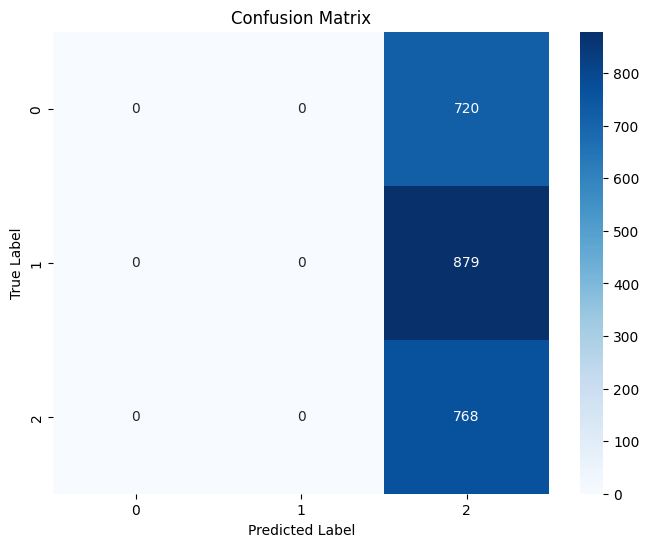

In [41]:
# Create the testing confusion matrix
cm = confusion_matrix(test_results['expected_label'], test_results['predicted_label'],labels=["ENTAILMENT","NEUTRAL","CONTRADICTION"])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [42]:
report_dict = classification_report(test_results['expected_label'], test_results['predicted_label'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose() 
report_df.columns.name = 'label'
report_df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


label,precision,recall,f1-score,support
CONTRADICTION,0.324461,1.000000,0.489952,768.000000
ENTAILMENT,0.000000,0.000000,0.000000,720.000000
NEUTRAL,0.000000,0.000000,0.000000,879.000000
accuracy,0.324461,0.324461,0.324461,0.324461
macro avg,0.108154,0.333333,0.163317,2367.000000
weighted avg,0.105275,0.324461,0.158971,2367.000000


In [43]:
metrics_by_type = test_results.groupby('type').apply(compute_metrics_by_type).reset_index()
metrics_by_type.columns.name = 'ID'
metrics_by_type

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined 

ID,type,accuracy,precision,recall,f1_score
0,type1_again,0.40,1.0,0.40,0.57
1,type1_possessive,0.40,1.0,0.40,0.57
2,type2_again,0.40,1.0,0.40,0.57
3,type2_possessive,0.40,1.0,0.40,0.57
4,type3_again,0.40,1.0,0.40,0.57
5,type3_possessive,0.40,1.0,0.40,0.57
6,type4_possessive,0.37,1.0,0.37,0.54
7,type5_again,0.01,1.0,0.01,0.02
8,type5_possessive,0.33,1.0,0.33,0.49


## facebook/roberta-large-mnli 

In [66]:
checkpoint = "FacebookAI/roberta-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [67]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at FacebookAI/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [68]:
tokenized_train_ds = train_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
tokenized_val_ds = val_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/1908 [00:00<?, ? examples/s]

Map:   0%|          | 0/478 [00:00<?, ? examples/s]

In [69]:
len(val_ds)

478

In [70]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2, # Set the number of epochs to 1
    logging_steps=100,
    # evaluation_strategy="steps",
    eval_steps=100,
    evaluation_strategy="epoch",  # Evaluate during training
    # evaluation_strategy="no",
    save_strategy="epoch",  # Save the model at the end of each epoch
    load_best_model_at_end=True,  # Load the best model at the end of training
    report_to="none",
    fp16=True
)
trainer = Trainer(
    model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_val_ds,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[]
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-70-f4b124f3c7cc>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [71]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Gmean
1,0.561500,0.620440,0.797071,0.744437,0.797071,0.760178,0.521070
2,0.473300,0.514479,0.811715,0.783144,0.811715,0.796035,0.647351


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=478, training_loss=0.5458907682027777, metrics={'train_runtime': 757.4741, 'train_samples_per_second': 5.038, 'train_steps_per_second': 0.631, 'total_flos': 3556262098280448.0, 'train_loss': 0.5458907682027777, 'epoch': 2.0})

In [72]:
trainer.save_model("roberta-large-mnli")

In [50]:
if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU")
    device = torch.device("cpu")

GPU is available!


In [37]:
model = AutoModelForSequenceClassification.from_pretrained('ConditionalNLI/exp3_roberta-large-mnli',num_labels=3).to(device)

In [40]:
trainer.train(resume_from_checkpoint=True)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3418: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Gmean
300,0.402100,0.533843,0.832636,0.805418,0.832636,0.817321,0.678923
400,0.489500,0.516850,0.817992,0.783886,0.817992,0.751352,0.470971


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=478, training_loss=0.22376699726950675, metrics={'train_runtime': 402.9653, 'train_samples_per_second': 9.47, 'train_steps_per_second': 1.186, 'total_flos': 3556262098280448.0, 'train_loss': 0.22376699726950675, 'epoch': 2.0})

In [41]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.5066624879837036,
 'eval_accuracy': 0.8179916317991632,
 'eval_precision': 0.8179301009106571,
 'eval_recall': 0.8179916317991632,
 'eval_f1_score': 0.8166969217251964,
 'eval_gmean': 0.7423397836784894,
 'eval_runtime': 25.291,
 'eval_samples_per_second': 18.9,
 'eval_steps_per_second': 2.372,
 'epoch': 2.0}

In [43]:
trainer.save_model("roberta-large-mnli")

In [ ]:
# uploading to HuggingFace 
from huggingface_hub import login

login(new_session=False, # Won’t request token if one is already saved on machine
write_permission=True, # Requires a token with write permission
token="", # The name of your token
add_to_git_credential=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in 'login': write_permission. Will not be supported from version '1.0'.

Fine-grained tokens added complexity to the permissions, making it irrelevant to check if a token has 'write' access.
  warnings.warn(message, FutureWarning)
Token has not been saved to git credential helper.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [74]:
from huggingface_hub import HfApi
api = HfApi()

# Upload all the content from the local folder to your remote Space.
# By default, files are uploaded at the root of the repo
api.upload_folder(
    folder_path='/kaggle/working/roberta-large-mnli',
    repo_id="ConditionalNLI/exp3_roberta-large-mnli",
)

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/ConditionalNLI/exp3_roberta-large-mnli/commit/e34b896049701d6069f2dbc5b7486428e871be8a', commit_message='Upload folder using huggingface_hub', commit_description='', oid='e34b896049701d6069f2dbc5b7486428e871be8a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ConditionalNLI/exp3_roberta-large-mnli', endpoint='https://huggingface.co', repo_type='model', repo_id='ConditionalNLI/exp3_roberta-large-mnli'), pr_revision=None, pr_num=None)

### Inferencing

In [75]:
from transformers import pipeline
from datasets import load_dataset, Dataset
from transformers.pipelines.pt_utils import KeyDataset, KeyPairDataset
import torch

In [54]:
if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU")
    device = torch.device("cpu")

GPU is available!


In [76]:
# loading model
model = AutoModelForSequenceClassification.from_pretrained('ConditionalNLI/exp3_roberta-large-mnli',num_labels=3).to(device)

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [77]:
gen = pipeline('text-classification', model=model, tokenizer=tokenizer, device=device)

Device set to use cuda


In [78]:
id_num = 0
test_results = pd.DataFrame(columns = ['id', 'premise', 'hypothesis', 'type', 'expected_label', 'predicted_label'])

for predicted in gen(KeyPairDataset(test_ds,'premise', 'hypothesis'), batch_size=8, truncation=True):
    if id_num % 100 == 0:
        print(id_num)
    test_results.loc[id_num] = [str(id_num), test_ds['premise'][id_num], test_ds['hypothesis'][id_num], test_ds['type'][id_num], test_ds['label'][id_num], predicted['label']]
    id_num += 1

len(test_results)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


2367

In [58]:
test_results

,id,premise,hypothesis,type,expected_label,predicted_label
0,0,"If Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT,CONTRADICTION
1,1,"It's not the case that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT,CONTRADICTION
2,2,"Sam believes that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT,CONTRADICTION
3,3,"Is it true that if Charlotte passes her driving test, her parents will buy her a car?",Charlotte has parents.,type5_possessive,ENTAILMENT,CONTRADICTION
4,4,"If Lily takes the train to the city, her friend will meet her at the station.",Lily has a friend.,type5_possessive,ENTAILMENT,CONTRADICTION
...,...,...,...,...,...,...
2362,2362,"If Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL,CONTRADICTION
2363,2363,"It's not the case that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL,CONTRADICTION
2364,2364,"Sam believes that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL,CONTRADICTION
2365,2365,"Is it true that if Sophia decides to attend the concert, his best friend will drive him there?",Sophia has a close friend.,type5_possessive,NEUTRAL,CONTRADICTION


In [79]:
test_results['predicted_label'].value_counts()

predicted_label
CONTRADICTION    2317
NEUTRAL            50
Name: count, dtype: int64

In [81]:
test_results.to_csv('roberta-mnli_test_results_run3.csv')

In [83]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

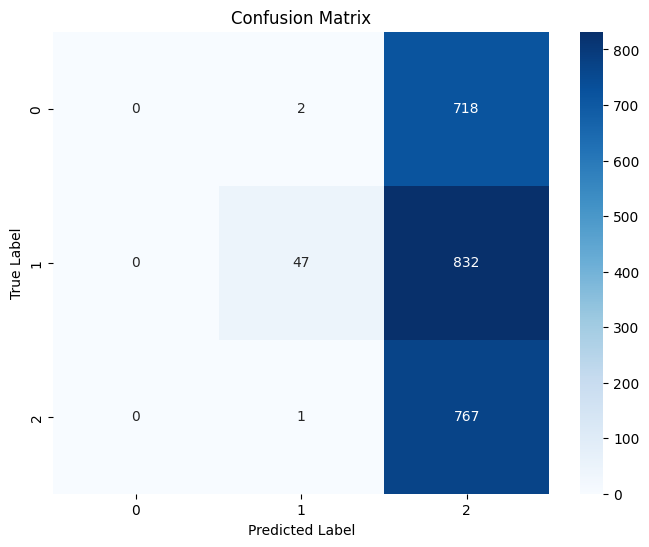

In [84]:
# Create the testing confusion matrix
cm = confusion_matrix(test_results['expected_label'], test_results['predicted_label'],labels=["ENTAILMENT","NEUTRAL","CONTRADICTION"])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [85]:
report_dict = classification_report(test_results['expected_label'], test_results['predicted_label'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose() 
report_df.columns.name = 'label'
report_df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


label,precision,recall,f1-score,support
CONTRADICTION,0.331032,0.998698,0.497245,768.000000
ENTAILMENT,0.000000,0.000000,0.000000,720.000000
NEUTRAL,0.940000,0.053470,0.101184,879.000000
accuracy,0.343895,0.343895,0.343895,0.343895
macro avg,0.423677,0.350723,0.199476,2367.000000
weighted avg,0.456482,0.343895,0.198912,2367.000000


In [86]:
metrics_by_type = test_results.groupby('type').apply(compute_metrics_by_type).reset_index()
metrics_by_type.columns.name = 'ID'
metrics_by_type

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined 

ID,type,accuracy,precision,recall,f1_score
0,type1_again,0.40,1.00,0.40,0.57
1,type1_possessive,0.48,0.93,0.48,0.58
2,type2_again,0.45,0.95,0.45,0.57
3,type2_possessive,0.41,0.99,0.41,0.57
4,type3_again,0.40,0.97,0.40,0.56
5,type3_possessive,0.42,0.98,0.42,0.57
6,type4_possessive,0.39,0.99,0.39,0.54
7,type5_again,0.01,1.00,0.01,0.02
8,type5_possessive,0.34,0.99,0.34,0.50
